In [1]:
import os
import tensorflow as tf
import cv2
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import gc

In [2]:
data_dir="/kaggle/input/tomato-plant-disease/Tomato-dataset"
class_names = ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Healthy', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Mosaic_virus', 'Tomato_Septoria_leafspot', 'Tomato_Spider_mites', 'Tomato_Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus']
image_exts = ['jpeg','jpg', 'bmp', 'png']
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)

In [3]:
# Data Augmentation using Sequential model
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

# Function to apply augmentation to a dataset
def augment_data(dataset):
    return dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

In [4]:
def build_cnn() :
  input_shape=(256,256,3)
  num_classes=10

  model=Sequential()
  model.add(Conv2D(32, (3, 3), activation="relu", input_shape=input_shape))
  model.add(MaxPooling2D())
  model.add(Dropout(0.3))

  model.add(Conv2D(64, (3, 3), activation="relu"))
  model.add(MaxPooling2D())
  model.add(Dropout(0.3))

  model.add(Conv2D(128, (3, 3), activation="relu"))
  model.add(MaxPooling2D())
  model.add(Dropout(0.3))

  model.add(Conv2D(256, (3, 3), activation="relu"))
  model.add(MaxPooling2D())
  model.add(Dropout(0.3))

  model.add(Conv2D(512, (3, 3), activation="relu"))
  model.add(MaxPooling2D())
  model.add(Dropout(0.3))

  model.add(Flatten())
  model.add(Dense(256, activation="relu", kernel_regularizer=l2(0.001)))
  model.add(Dropout(0.5))
  model.add(Dense(128, activation="relu", kernel_regularizer=l2(0.001)))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation="softmax", kernel_regularizer=l2(0.001)))

  model.compile(
      optimizer="adam",
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
      metrics=["accuracy"]
  )
  #model.summary()
  return model
model = build_cnn()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
data = tf.keras.utils.image_dataset_from_directory(data_dir, batch_size = None, class_names=class_names)

train_size = 0.7
val_size = 0.15
test_size = 0.15

dataset_size = len(data)
train_samples = int(train_size * dataset_size)
val_samples = int(val_size * dataset_size)
test_samples = dataset_size - train_samples - val_samples

data = data.shuffle(buffer_size=512, seed=42)

# Split the dataset
train_dataset = data.take(train_samples)
val_dataset = data.skip(train_samples).take(val_samples)
test_dataset = data.skip(train_samples + val_samples)

#Add augmentation to the training dataset only
train_dataset_aug = augment_data(train_dataset)

# Combine the original and augmented datasets
train_dataset = train_dataset.concatenate(train_dataset_aug)

# Shuffle and prepare the dataset
train_dataset = train_dataset.shuffle(buffer_size=128, seed=42)
train_dataset = train_dataset.take(len(train_dataset) // 2)

Found 41800 files belonging to 10 classes.


In [21]:
train_dataset = train_dataset.map(lambda x,y: (x/255, y))
train_dataset = train_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.map(lambda x,y: (x/255, y))
val_dataset = val_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.map(lambda x,y: (x/255, y))
test_dataset = test_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

In [22]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',        # Where to save the model
    monitor='val_loss',              # What to monitor (you can change it to 'loss' for training loss)
    mode='min',                      # Mode 'min' because we want to minimize the loss
    verbose=1                        # Print info when saving the model
)
history = model.fit(
    train_dataset,
    epochs=35,
    validation_data=val_dataset,
    callbacks=[checkpoint_callback]
)

Epoch 1/35
458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.2428 - loss: 2.4342

I0000 00:00:1727239730.163230     100 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_1', 4 bytes spill stores, 12 bytes spill loads




Epoch 1: saving model to best_model.keras
458/458 ━━━━━━━━━━━━━━━━━━━━ 86s 163ms/step - accuracy: 0.2430 - loss: 2.4333 - val_accuracy: 0.6155 - val_loss: 1.3441
Epoch 2/35
458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6106 - loss: 1.3209
Epoch 2: saving model to best_model.keras
458/458 ━━━━━━━━━━━━━━━━━━━━ 55s 120ms/step - accuracy: 0.6107 - loss: 1.3206 - val_accuracy: 0.5056 - val_loss: 1.7613
Epoch 3/35
458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7489 - loss: 0.9524
Epoch 3: saving model to best_model.keras
458/458 ━━━━━━━━━━━━━━━━━━━━ 56s 121ms/step - accuracy: 0.7490 - loss: 0.9523 - val_accuracy: 0.7930 - val_loss: 0.7806
Epoch 4/35
458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7808 - loss: 0.8536
Epoch 4: saving model to best_model.keras
458/458 ━━━━━━━━━━━━━━━━━━━━ 55s 119ms/step - accuracy: 0.7808 - loss: 0.8535 - val_accuracy: 0.7901 - val_loss: 0.8093
Epoch 5/35
458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8249 - loss: 0.7337
Epo

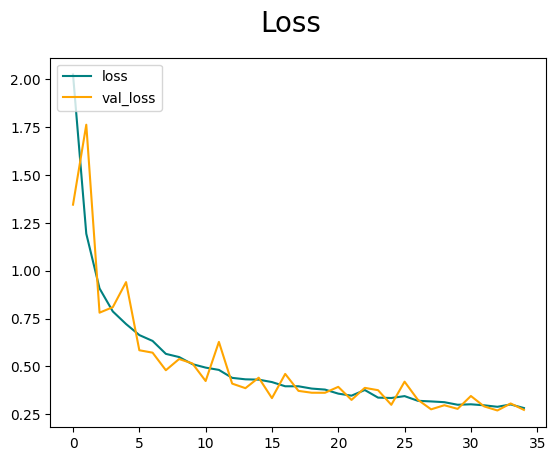

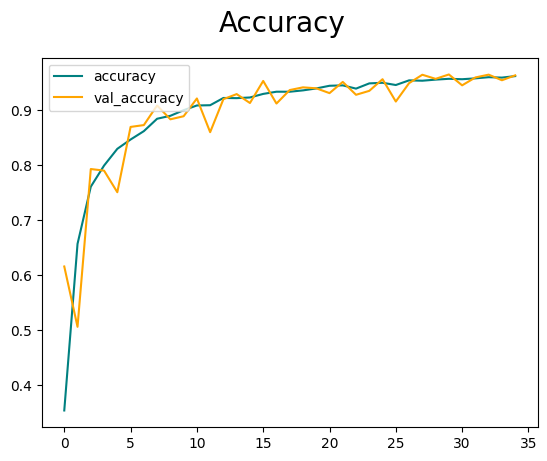

In [23]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [24]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy}")
print(f"Test loss: {test_loss}")

98/98 ━━━━━━━━━━━━━━━━━━━━ 31s 94ms/step - accuracy: 0.9658 - loss: 0.2675
Test accuracy: 0.9657151699066162
Test loss: 0.2662387490272522


# Generate Segmentation Dataset and Train UNET

In [ ]:
!rm -r masked_samples

In [5]:
def create_colored_mask(image):
    image_np = image
    hsv = cv2.cvtColor(image_np, cv2.COLOR_RGB2HSV)
    lower_green = np.array([25, 0, 0])
    upper_green = np.array([185, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)
    #mask_inv = cv2.bitwise_not(mask)
    mask_3channel = cv2.merge([mask, mask, mask])
    image_np = image_np.astype(np.uint8)
    mask_3channel = mask_3channel.astype(np.uint8)
    masked_image = cv2.bitwise_and(image_np, mask_3channel)
    return masked_image

def visualize_masked_image(masked_image, image_np):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Masked Image")
    plt.imshow(masked_image)
    plt.subplot(1, 2, 2)
    plt.title("Original Image")
    plt.imshow(image_np)
    plt.show()

def save_img(image, file_path):
    cv2.imwrite(file_path, image)

def process_and_save_masked_image(image, index):
    masked_image = create_colored_mask(image)
    #visualize_masked_image(masked_image, image.astype(np.int32))
    save_dir = 'masked_mini_samples'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir+'/inputs')
        os.makedirs(save_dir+'/masks')
    file_path = os.path.join(save_dir, 'inputs', f'image_{index}.png')
    save_img(image, file_path)
    file_path = os.path.join(save_dir, 'masks', f'image_{index}.png')
    save_img(masked_image, file_path)

def process_batch(dataset):
    for index, (image, label) in enumerate(dataset):
        process_and_save_masked_image(image.numpy(), index)

In [14]:
def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D(pool_size=(2, 2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)

    # Decoder
    u4 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(c4)

    u5 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c1])
    c5 = layers.Conv2D(64, 3, activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(64, 3, activation='relu', padding='same')(c5)

    # Output layer with 3 channels for RGB output
    outputs = layers.Conv2D(3, 1, activation='sigmoid')(c5)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Compile U-Net model
unet = unet_model()
unet.compile(optimizer=tf.keras.optimizers.Adam(0.00005), loss='binary_crossentropy', metrics=['accuracy'])
#plot_model(unet, show_shapes=True)
#unet.summary()

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(data_dir, batch_size=None)
data = data.shuffle(buffer_size=256, seed=13)
process_batch(data.take(len(data)//20))
del data

In [15]:
tf.keras.backend.clear_session()
gc.collect()

0

In [16]:
input_dir = 'masked_mini_samples/inputs/'
mask_dir = 'masked_mini_samples/masks/'

# Helper function to load and preprocess image
def load_image(img_path, mask_path):
    # Load and decode the images
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [256, 256])

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.image.resize(mask, [256, 256])

    return img/255.0, mask/255.0

# Helper function to load dataset
def load_dataset(input_dir, mask_dir):
    # Get the list of input and mask file paths
    input_paths = [os.path.join(input_dir, fname) for fname in sorted(os.listdir(input_dir))]
    mask_paths = [os.path.join(mask_dir, fname) for fname in sorted(os.listdir(mask_dir))]

    # Create a dataset of file paths
    dataset = tf.data.Dataset.from_tensor_slices((input_paths, mask_paths))

    # Map the file paths to the actual images and masks
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

    return dataset

class_names = ['Tomato_Leaf_Mold', 'Tomato_Spider_mites', 'Tomato_Late_blight', 'Tomato_Early_blight', 'Tomato_Mosaic_virus', 'Tomato_Septoria_leafspot', 'Tomato_Bacterial_spot', 'Tomato_Healthy', 'Tomato_Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus']
# Load the dataset
dataset = load_dataset(input_dir, mask_dir)
dataset_size = len(os.listdir(input_dir))  # Calculate dataset size correctly

# Splitting dataset into training and validation sets
train_size = 0.8
val_size = 0.2

train_samples = int(train_size * dataset_size)
val_samples = dataset_size - train_samples

train_dataset = dataset.take(train_samples)
val_dataset = dataset.skip(train_samples).take(val_samples)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

def augment_data_unet(dataset):
    def apply_augmentation_unet(image, mask):
        # Concatenate image and mask along the channel dimension (axis=-1) so they get augmented together
        concatenated = tf.concat([image, mask], axis=-1)
        augmented = data_augmentation(concatenated, training=True)
        
        # Split the augmented result back into image and mask (since they were concatenated)
        augmented_image = augmented[..., :image.shape[-1]]  # First part is the image
        augmented_mask = augmented[..., image.shape[-1]:]  # Second part is the mask
        return augmented_image, augmented_mask
    
    return dataset.map(lambda x, y: apply_augmentation_unet(x, y), num_parallel_calls=tf.data.AUTOTUNE)

# Apply augmentation to the training dataset only
train_dataset_aug = augment_data_unet(train_dataset)

# Combine the original and augmented datasets
train_dataset = train_dataset.concatenate(train_dataset_aug)

# Shuffle and prepare the dataset
train_dataset = train_dataset.shuffle(buffer_size=128, seed=13)
train_dataset = train_dataset.take(len(train_dataset) // 2)

# Batch and prefetch
train_dataset = train_dataset.shuffle(buffer_size=64, seed=13).batch(50).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=64, seed=13).batch(50).prefetch(tf.data.AUTOTUNE)

In [17]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_unet_model.keras',        # Where to save the model
    monitor='val_loss',              # What to monitor (you can change it to 'loss' for training loss)
    mode='min',                      # Mode 'min' because we want to minimize the loss
    verbose=1                        # Print info when saving the model
)
history = unet.fit(train_dataset, epochs=8, validation_data=val_dataset, callbacks=[checkpoint_callback])

Epoch 1/8


I0000 00:00:1727272364.127145     104 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_23', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_20', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_19', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_18', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_17', 4 bytes spill stores, 12 bytes spill loads



33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.3642 - loss: 0.6854

I0000 00:00:1727272390.486824     103 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_1', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_3', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_2', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_17', 4 bytes spill stores, 12 bytes spill loads



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 788ms/step - accuracy: 0.3607 - loss: 0.6849
Epoch 1: saving model to best_unet_model.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 950ms/step - accuracy: 0.3574 - loss: 0.6845 - val_accuracy: 0.0685 - val_loss: 0.5884
Epoch 2/8
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.1843 - loss: 0.5287
Epoch 2: saving model to best_unet_model.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 35s 853ms/step - accuracy: 0.1877 - loss: 0.5280 - val_accuracy: 0.4117 - val_loss: 0.4718
Epoch 3/8
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.4290 - loss: 0.4762
Epoch 3: saving model to best_unet_model.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 29s 845ms/step - accuracy: 0.4291 - loss: 0.4760 - val_accuracy: 0.4362 - val_loss: 0.4453
Epoch 4/8
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.4398 - loss: 0.4380
Epoch 4: saving model to best_unet_model.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 29s 842ms/step - accuracy: 0.4397 - loss: 0.4375 - val_accuracy: 0.4312 - val_loss: 0.3702
Epoch 5/8


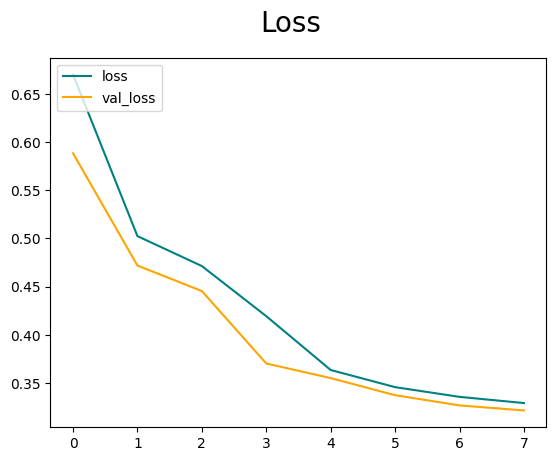

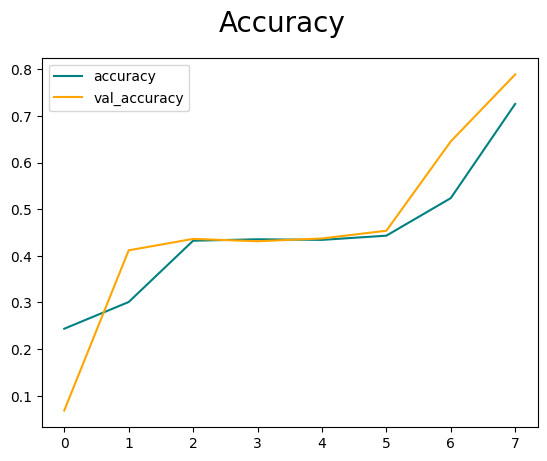

In [18]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Training CNN on segmented dataset

In [ ]:
from PIL import Image

output_dir = 'masked_images'
os.makedirs(output_dir, exist_ok=True)

data = tf.keras.utils.image_dataset_from_directory(data_dir, batch_size=128)
data = data.map(lambda x, y: (x / 255, y))  # Normalize the images and keep the labels
data = data.prefetch(tf.data.AUTOTUNE)

# Iterate through the batches of data and generate predictions
for i, (batch, labels) in enumerate(data):
    # Get the model's predictions
    predictions = unet.predict(batch)

    # Post-process the predictions (convert from float [0,1] to uint8 [0,255])
    predictions = np.clip(predictions * 255, 0, 255).astype(np.uint8)

    # Iterate through the batch and save each image
    for j in range(predictions.shape[0]):
        img = predictions[j]
        img = Image.fromarray(img)

        # Get the class name for the current label
        class_name = class_names[labels[j]]

        # Define the directory to save the image
        class_dir = os.path.join(output_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

        # Define the file path to save the image
        file_path = os.path.join(class_dir, f'masked_image_{i}_{j}.png')
        img.save(file_path)

print(f"Images saved in {output_dir}")

In [4]:
data = tf.keras.utils.image_dataset_from_directory('masked_images', batch_size = None)

train_size = 0.7
val_size = 0.15
test_size = 0.15

dataset_size = len(data)
train_samples = int(train_size * dataset_size)
val_samples = int(val_size * dataset_size)
test_samples = dataset_size - train_samples - val_samples

data = data.shuffle(buffer_size=512, seed=42)

train_dataset = data.take(train_samples)
val_dataset = data.skip(train_samples).take(val_samples)
test_dataset = data.skip(train_samples + val_samples)

train_dataset_aug = augment_data(train_dataset)
train_dataset = train_dataset.concatenate(train_dataset_aug)
train_dataset = train_dataset.shuffle(buffer_size=512, seed=42)
train_dataset = train_dataset.take(len(train_dataset)//6)

Found 79024 files belonging to 10 classes.


In [5]:
train_dataset = train_dataset.map(lambda x,y: (x/255, y))
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.map(lambda x,y: (x/255, y))
val_dataset = val_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.map(lambda x,y: (x/255, y))
test_dataset = test_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

In [97]:
model = build_cnn()

In [98]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_segmented_cnn.keras',        # Where to save the model
    monitor='val_loss',              # What to monitor (you can change it to 'loss' for training loss)
    mode='min',                      # Mode 'min' because we want to minimize the loss
    verbose=1                        # Print info when saving the model
)
history = model.fit(
    train_dataset,
    epochs=35,
    validation_data=val_dataset,
    callbacks=[checkpoint_callback]
)

Epoch 1/35
577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2231 - loss: 2.4521
Epoch 1: saving model to best_segmented_cnn.keras
577/577 ━━━━━━━━━━━━━━━━━━━━ 99s 150ms/step - accuracy: 0.2232 - loss: 2.4516 - val_accuracy: 0.4266 - val_loss: 1.7320
Epoch 2/35
575/577 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4028 - loss: 1.7760
Epoch 2: saving model to best_segmented_cnn.keras
577/577 ━━━━━━━━━━━━━━━━━━━━ 76s 131ms/step - accuracy: 0.4029 - loss: 1.7758 - val_accuracy: 0.5021 - val_loss: 1.5350
Epoch 3/35
575/577 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4856 - loss: 1.5943
Epoch 3: saving model to best_segmented_cnn.keras
577/577 ━━━━━━━━━━━━━━━━━━━━ 78s 133ms/step - accuracy: 0.4856 - loss: 1.5942 - val_accuracy: 0.5491 - val_loss: 1.4128
Epoch 4/35
576/577 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5357 - loss: 1.4928
Epoch 4: saving model to best_segmented_cnn.keras
577/577 ━━━━━━━━━━━━━━━━━━━━ 78s 133ms/step - accuracy: 0.5358 - loss: 1.4927 - val_accuracy

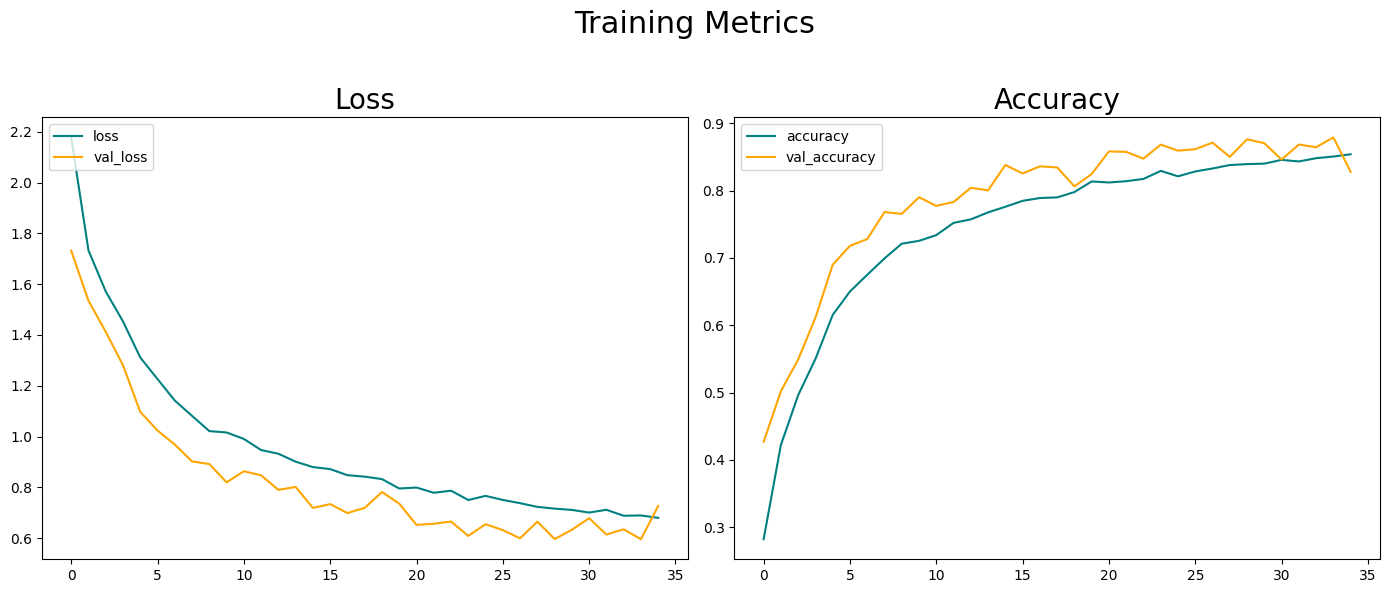

In [99]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot the loss and validation loss on the first subplot
axs[0].plot(history.history['loss'], color='teal', label='loss')
axs[0].plot(history.history['val_loss'], color='orange', label='val_loss')
axs[0].set_title('Loss', fontsize=20)
axs[0].legend(loc="upper left")

# Plot the accuracy and validation accuracy on the second subplot
axs[1].plot(history.history['accuracy'], color='teal', label='accuracy')
axs[1].plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
axs[1].set_title('Accuracy', fontsize=20)
axs[1].legend(loc="upper left")

# Set the overall title
fig.suptitle('Training Metrics', fontsize=22)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the figure to a file
plt.savefig('training_metrics.png')

# Show the plot
plt.show()

In [6]:
model = tf.keras.models.load_model('/kaggle/working/best_segmented_cnn.keras')
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy}")
print(f"Test loss: {test_loss}")

I0000 00:00:1727324936.729454     102 service.cc:145] XLA service 0x79f3a8005340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727324936.729523     102 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  6/186 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8394 - loss: 0.6968   

I0000 00:00:1727324940.398736     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


186/186 ━━━━━━━━━━━━━━━━━━━━ 68s 63ms/step - accuracy: 0.8363 - loss: 0.6820
Test accuracy: 0.8367777466773987
Test loss: 0.6881948709487915


In [6]:
test_dir = '/kaggle/input/tomato-leaf-disease-test/tomato-disease-test-22/test_imgs/test_imgs/Tomato_Bacterial_spot'
dataset_bs = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(256, 256),  # Adjust image size according to your segmentation model
    batch_size=None,
    labels=None
)
dataset_bs = dataset_bs.map(lambda x: (x/255, 6))
test_dir = '/kaggle/input/tomato-leaf-disease-test/tomato-disease-test-22/test_imgs/test_imgs/Tomato_Early_blight'
dataset_eb = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(256, 256),  # Adjust image size according to your segmentation model
    batch_size=None,
    labels=None
)
dataset_eb = dataset_eb.map(lambda x: (x/255, 3))
test_dir = '/kaggle/input/tomato-leaf-disease-test/tomato-disease-test-22/test_imgs/test_imgs/Tomato_Spider_mites'
dataset_sm = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(256, 256),  # Adjust image size according to your segmentation model
    batch_size=None,
    labels=None
)
dataset_sm = dataset_sm.map(lambda x: (x/255, 1))
test_dataset=dataset_bs.concatenate(dataset_eb).concatenate(dataset_sm)

segmentation_model = tf.keras.models.load_model('/kaggle/working/best_unet_model.keras')

images = []
labels = []
orig_img = []
for img_batch, label_batch in test_dataset:
    segmentation_mask = segmentation_model.predict(np.expand_dims(img_batch.numpy(), axis=0))
    segmentation_mask = tf.squeeze(segmentation_mask, axis=0)
    orig_img.append(img_batch.numpy())
    images.append(segmentation_mask.numpy())
    labels.append(label_batch.numpy())

# Concatenate the lists into NumPy arrays
test_images_np = np.array(images)  # Shape (num_samples, 256, 256, 3)
test_labels_np = np.array(labels)  # Shape (num_samples,)
orig_img_np = np.array(orig_img)

Found 2 files.
Found 2 files.
Found 2 files.


I0000 00:00:1727254896.370483     102 service.cc:145] XLA service 0x7d9930004190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727254896.370532     102 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


I0000 00:00:1727254898.197943     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [7]:
test_labels_preds = model.predict(test_images_np)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step


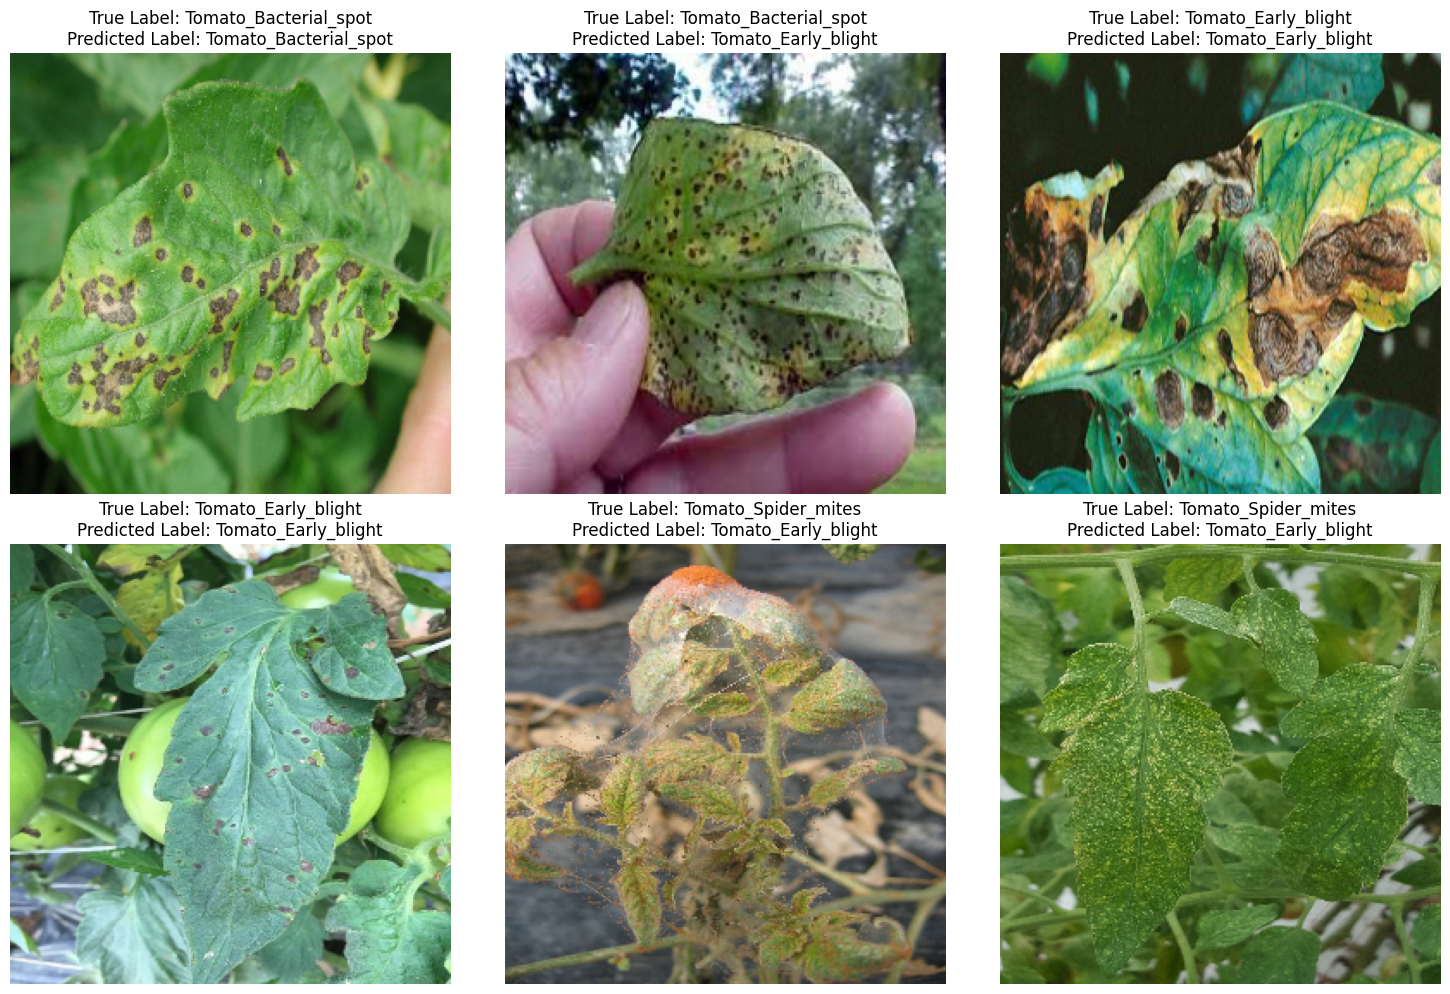

In [11]:
def display_images(images, true_labels, pred_labels, cols=3, figsize=(15, 10)):
    rows = 2
    plt.figure(figsize=figsize)
    
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image)
        plt.title(f'True Label: {class_names[true_labels[i]]}\nPredicted Label: {class_names[pred_labels[i].argmax()]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

display_images(orig_img_np, test_labels_np, test_labels_preds)

# GAN

In [8]:
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array

def build_generator(noise_dim):
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, activation='relu', input_dim=noise_dim))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(256*256*3, activation='tanh'))
    model.add(layers.Reshape((256, 256, 3)))
    return model

# Define the Discriminator model
def build_discriminator(image_shape):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, input_shape=image_shape, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Combine Generator and Discriminator to create the GAN model
def build_gan(generator, discriminator):
    discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    discriminator.trainable = False
    gan_input = layers.Input(shape=(100,))
    generated_image = generator(gan_input)
    gan_output = discriminator(generated_image)
    gan = tf.keras.models.Model(gan_input, gan_output)
    gan.compile(optimizer='adam', loss='binary_crossentropy')
    return gan

# Load the dataset using image_dataset_from_directory
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(256, 256),
    batch_size=64,
    shuffle=True)
dataset = dataset.take(len(dataset)//20)
num_classes = len(class_names)
image_shape = (256, 256, 3)
noise_dim = 100

# Initialize the models
generator = build_generator(noise_dim)
discriminator = build_discriminator(image_shape)
generator.summary()
discriminator.summary()
gan = build_gan(generator, discriminator)

Found 41800 files belonging to 10 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 196608)         │   201,523,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 256, 256, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,213,120 (771.38 MB)

 Trainable params: 202,209,536 (771.37 MB)

 Non-trainable params: 3,584 (14.00 KB)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │       524,289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 599,937 (2.29 MB)

 Trainable params: 599,937 (2.29 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('gan_generated_images', batch_size = None)

train_size = 0.7
val_size = 0.15
test_size = 0.15

dataset_size = len(data)
train_samples = int(train_size * dataset_size)
val_samples = int(val_size * dataset_size)
test_samples = dataset_size - train_samples - val_samples

data = data.shuffle(buffer_size=1024, seed=42)

train_dataset = data.take(train_samples)
val_dataset = data.skip(train_samples).take(val_samples)
test_dataset = data.skip(train_samples + val_samples)

# DEMO

# others